In [1]:
# Imports and environment setup
# General Utilities & Environment
import os
import dotenv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
os.makedirs("OutputData", exist_ok=True)
dotenv.load_dotenv(dotenv.find_dotenv(filename=".env"))
from dask.distributed import Client, LocalCluster

# API Calls: Data Collection & Standardization
import api_wrappers as aw

# Tsfresh-Xgboost-Optuna Pipeline
import tsxg_pipeline as tsxg

2025-09-21 13:45:21,896 INFO numba.cuda.cudadrv.driver init
2025-09-21 13:45:22,564 WARNING tsfresh.feature_extraction.settings Dependency not available for matrix_profile, this feature will be disabled!
2025-09-21 13:45:22,566 WARNING tsfresh.feature_extraction.settings Dependency not available for matrix_profile, this feature will be disabled!


In [2]:
# Key Variables & Parameters
TIMEZONE = os.environ.get("TZ")
YEARS_BACK = 1
DAYS_BACK = 365 * YEARS_BACK 
TARGET_COIN = "ethereum"
TSFRESH_PRESET = "Comprehensive"   # "Minimal" | "Efficient" | "Comprehensive"
MAX_TIMESHIFT = 7
FDR_LEVEL = 0.10
CG_TOP_N = 10
XGB_PARAMGRID = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "eta": [0.01, 0.025, 0.05, 0.1, 0.2, 0.3],
    "min_child_weight": [1.0, 2.0, 3.0, 5.0, 7.0, 10.0],
    "subsample": [0.5, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.7, 0.8, 0.9, 1.0],
    "n_estimators": [100, 300, 600, 1000],
    "objective": ["reg:squarederror"],
    "tree_method": ["hist"],  # or "gpu_hist" if GPU available
    "eval_metric": ["mae"],
    "verbosity": [0],
}
KEY_VARIABLE_PARAMGRID = {
    "max_timeshift": [3, 5, 7, 10, 14],
    "fdr_level": [0.05, 0.1, 0.15, 0.2],
    "tsfresh_preset": ["Minimal", "Efficient", "Comprehensive"],
    "cg_top_n": [5, 10, 15, 20],
}
# DUNE API
DUNE_QUERIES = {
    "economic_security": 1933076,
    "daily_dex_volume": 4388,
    "btc_etf_flows": 5795477,
    "eth_etf_flows": 5795645,
    "total_defi_users": 2972,
    "median_gas": 2981260,
}
DUNE_API_KEY = os.getenv("DUNE_API_KEY")
PREFER_DUNE_CSV = True
DUNE_CSV_PATH = "OutputData/Dune_Metrics.csv"
# Deribit API
DERIBIT_CURRENCY = "BTC"      # or "ETH"
DERIBIT_RESOLUTION = "1D"
# CoinGecko API
CG_API_KEY = os.getenv("COINGECKO_API_KEY")
CG_HEADERS = {
    "accept": "application/json",
    "x_cg_demo_api_key": CG_API_KEY
}
# FRED API 
FRED_API_KEY= os.getenv("FRED_API_KEY")
FRED_KNOWN = {
    "VIXCLS": "vix_equity_vol",           # CBOE VIX (daily)
    "MOVE":   "move_bond_vol",            # ICE BofA MOVE (Treasury vol)
    "OVXCLS": "ovx_oil_vol",              # CBOE Crude Oil Volatility Index
    "GVZCLS": "gvz_gold_vol",             # CBOE Gold Volatility Index
    "DTWEXBGS": "usd_trade_weighted_index", # Trade-Weighted U.S. Dollar Index, Broad Goods
    "DGS2": "us_2y_treasury_yield",         # U.S. 2-Year Treasury constant-maturity yield, %
    "DGS10": "us_10y_treasury_yield",       # U.S. 10-Year Treasury constant-maturity yield, %
}

In [3]:
# CPU optimized cluster for my CPU 
cluster = LocalCluster(
            n_workers=3,
            threads_per_worker=6,
            processes=True,
            dashboard_address=':8787',
            resources = {'GPU':2}
        )
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 18,Total memory: 31.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59391,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:59406,Total threads: 6
Dashboard: http://127.0.0.1:59408/status,Memory: 10.56 GiB
Nanny: tcp://127.0.0.1:59394,


In [4]:
# API Calls: Data Collection and Standardization
universe = aw.cg_universe(n= CG_TOP_N, cg_headers= CG_HEADERS)
O = aw.cgpriceactiondaily(universe, DAYS_BACK, TIMEZONE, CG_HEADERS)
V = aw.deribit_dvol_daily_multi(("BTC","ETH"), DAYS_BACK, TIMEZONE)
U = aw.dune_metrics_daily(DUNE_CSV_PATH, TIMEZONE)
df= O.join(V).join(U).dropna()
M = aw.fetch_fred_series_df(list(FRED_KNOWN.keys()), "2015-01-01", TIMEZONE)
df = df.join(M).ffill().dropna()
df
# - VIXCLS   : CBOE Volatility Index (VIX) close, % (equity implied vol)
# - DTWEXBGS : Trade-Weighted U.S. Dollar Index, Broad Goods
# - DGS2     : U.S. 2-Year Treasury constant-maturity yield, %
# - DGS10    : U.S. 10-Year Treasury constant-maturity yield, %


Error for binancecoin: 'prices'
Error for solana: 'prices'
Error for usd-coin: 'prices'
Error for dogecoin: 'prices'
Error for staked-ether: 'prices'
Error for tron: 'prices'


,prices_bitcoin,marketcaps_bitcoin,total_volumes_bitcoin,prices_ethereum,marketcaps_ethereum,total_volumes_ethereum,prices_ripple,marketcaps_ripple,total_volumes_ripple,prices_tether,...,median_gas,median_eth_transfer_price,eth_etf_flows(usd),vixcls,ovxcls,gvzcls,dtwexbgs,dgs2,dgs10,term_spread_10y_2y
date,,,,,,,,,,,,,,,,,,,,,
2024-09-23,63582.599569,1.255899e+12,2.034937e+10,2582.847684,3.108409e+11,1.275959e+10,0.587948,3.316832e+10,9.928877e+08,1.000260,...,23.297760,1.263828,2.920966e+06,15.89,34.39,17.72,121.6870,3.57,3.75,0.18
2024-09-24,63327.026545,1.251095e+12,2.399885e+10,2647.993162,3.186661e+11,1.974037e+10,0.585064,3.302228e+10,1.121279e+09,0.999920,...,24.039121,1.337035,-7.848469e+07,15.39,33.76,19.26,121.3868,3.49,3.74,0.25
2024-09-25,64334.142749,1.271184e+12,3.149098e+10,2653.844345,3.195246e+11,1.658477e+10,0.591441,3.338093e+10,1.227142e+09,1.000050,...,22.060890,1.229208,6.275639e+07,15.41,34.40,19.13,121.6868,3.53,3.79,0.26
2024-09-26,63151.899594,1.245721e+12,2.608764e+10,2578.566360,3.098750e+11,1.400368e+10,0.583895,3.296539e+10,1.184865e+09,1.000612,...,19.372070,1.049851,4.430280e+07,15.37,39.76,18.82,121.3274,3.60,3.79,0.19
2024-09-27,65130.768840,1.287151e+12,3.799557e+10,2630.949837,3.168290e+11,1.668616e+10,0.590002,3.333829e+10,1.320296e+09,1.000071,...,14.027058,0.775616,3.828964e+05,16.96,39.62,18.59,121.3560,3.55,3.75,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-04,111711.519777,2.225366e+12,3.640608e+10,4449.867098,5.375498e+11,3.081835e+10,2.844011,1.691484e+11,4.282593e+09,1.000382,...,0.977605,0.091370,-2.815556e+08,15.30,35.03,18.33,121.1565,3.59,4.17,0.58
2025-09-05,110724.736377,2.204052e+12,3.870837e+10,4298.094661,5.193194e+11,2.989327e+10,2.797620,1.665539e+11,4.435280e+09,1.000135,...,0.706724,0.063838,2.929931e+07,15.18,33.33,18.30,120.5394,3.51,4.10,0.59
2025-09-06,110662.181126,2.204046e+12,5.602047e+10,4306.613513,5.198307e+11,3.795093e+10,2.816095,1.678682e+11,6.440057e+09,1.000183,...,0.337402,0.030534,0.000000e+00,15.18,33.33,18.30,120.5394,3.51,4.10,0.59


In [5]:
# Target and TC Container Constuction
target = 'ethereum'
df[f'log_returns_{target}']= np.log(df[f'prices_{target}']) - np.log(df[f'prices_{target}'].shift(1))
df[f'realized_vol_{target}'] = abs(df[f'log_returns_{target}'])
X= df.diff().dropna()
y = X[f'realized_vol_{target}'].shift(-1).dropna()

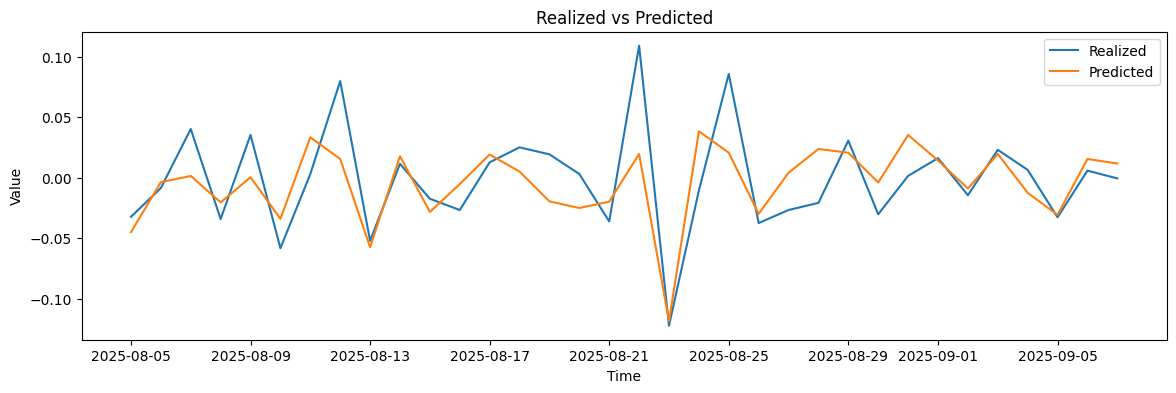

{'Best Score': 0.00040247638546111,
 'Best Score / Median': np.float64(0.020365395628241172),
 'MASE': np.float64(0.41600501725763134),
 'R^2': 0.4744658086116291}

In [6]:
# TSXG Pipeline Results
results= tsxg.tsxg_dask_distributor(X, y, scheduler_address=cluster.scheduler_address, maxtimeshift=5)
results['evaluation_metrics']

Feature Extraction: 100%|██████████| 90/90 [04:39<00:00,  3.11s/it] 


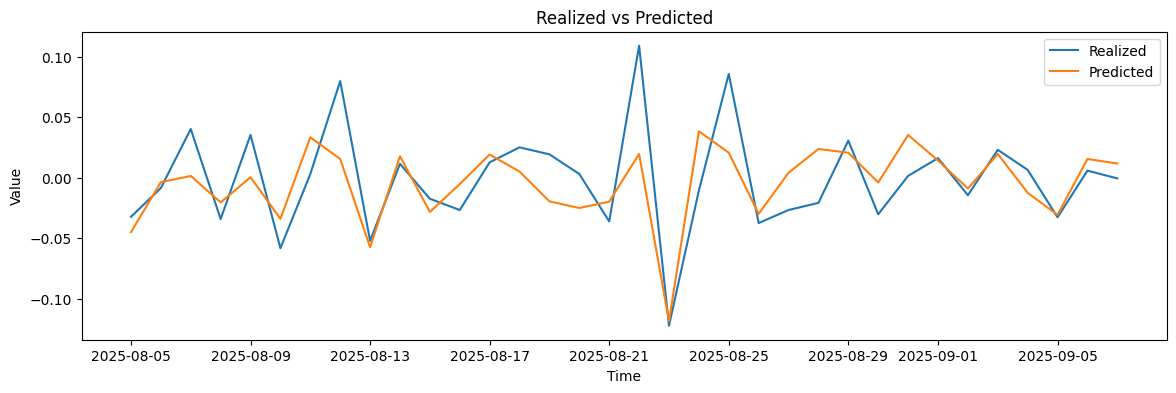

{'Best Score': 0.00040247638546111,
 'Best Score / Median': np.float64(0.020365395628241172),
 'MASE': np.float64(0.41600501725763134),
 'R^2': 0.4744658086116291}

In [7]:
results2 = tsxg.tsxg_multiprocessing(X, y, maxtimeshift=5)
results2['evaluation_metrics']

In [ ]:
# Hyperparameter tuning
# 1) Run the study (default sampler, no pruner)
import optuna

optuna_obj = tsxg.make_optuna_objective(X, y, scheduler_address=cluster.scheduler_address)  # you already have this
study = optuna.create_study(direction="minimize")
study.optimize(optuna_obj, n_trials=100, show_progress_bar=True)

# 2) Refit once with best params (minimal mapping)
best = study.best_params

# map tsfresh preset
_preset_map = {
    "Minimal": MinimalFCParameters,
    "Efficient": EfficientFCParameters,
    "Comprehensive": ComprehensiveFCParameters,
}
fc = _preset_map.get(best.get("tsfresh_preset", "Comprehensive"), ComprehensiveFCParameters)()

# build XGB with best (fallbacks to your usual defaults)
model = xgb.XGBRegressor(
    max_depth=best.get("max_depth", 5),
    eta=best.get("eta", 0.1),
    min_child_weight=best.get("min_child_weight", 3.0),
    subsample=best.get("subsample", 0.9),
    colsample_bytree=best.get("colsample_bytree", 0.9),
    n_estimators=best.get("n_estimators", 600),
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="mae",
    verbosity=0,
    early_stopping_rounds=10,
)

final = tsxg.tsxg(
    X, y,
    id="variable", sort="date",
    maxtimeshift=best.get("max_timeshift", MAX_TIMESHIFT),
    njobs=18,
    fcparameters=fc,
    fdrlvl=best.get("fdr_level", FDR_LEVEL),
    xgbmodel=model,
)

# 3) (Optional) Inspect/save results
study.best_value, study.best_params
